In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph, get_test_log_likelihood

# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- lower bound >0 ???
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [10]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def gram_matrix(xs):
    return np.array([[ard_kernel(x1,x2) for x2 in xs] for x1 in xs])

def ard_kernel(x1,x2):
    R = 2
    a = np.ones([R])*5
    g = 0.7
    return g * np.prod([np.exp(-1 * ((x1-x2) ** 2) / (2 * a[r])) for r in range(R)])

def gaussian_process_rate_function(xs):
    mean = [0 for x in xs]
    gram = gram_matrix(xs)
    result = np.random.multivariate_normal(mean, gram)

    return result

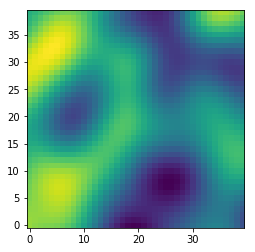

1.78417032878


In [11]:
Tmin = 0
Tmax = 10
upper_bound = 2

#generate samples
samples,test_samples, _,x_grid,vals,res = get_scp_samples(gaussian_process_rate_function, np.array([[Tmin, Tmax], [Tmin,Tmax]]), upper_bound)
                                                        

#plot the rate_function over a grid
plot_vals = vals.reshape(res,res)
plt.imshow(plot_vals, interpolation='none', origin='lower')
plt.show()

print(np.max(plot_vals))


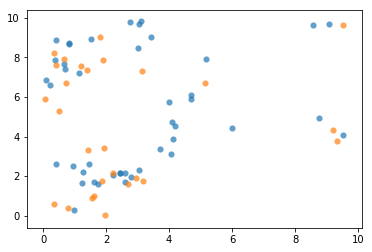

In [12]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.scatter(test_samples[:,0], test_samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

### 2D Parameter Learning

In [13]:
def train_parameters(res_inducing_points, alpha_init, data):
    ## ######## ##
    # PARAMETERS #
    ## ######## ##
    log_dir        = 'logs'
    max_iterations = 6000
    ind_point_res  = res_inducing_points
    learning_rate  =0.0001
    g_init = 0.3

    run_prefix = '2d_dummy_{}ipres_lr{}_{}iterations'.format(ind_point_res, learning_rate, max_iterations)

    # inducing point location
    Zx = np.linspace(1, 9, ind_point_res)[:,na]
    Zy = np.linspace(1, 9, ind_point_res)[:,na]

    xx_ind_points, yy_ind_points = np.meshgrid(Zx, Zy)

    Z = np.array([xx_ind_points, yy_ind_points]).transpose(1,2,0).reshape(ind_point_res**2, 2)

    # X = np.random.rand(10,2)*10

    ## ######### ##
    # BUILD GRAPH #
    ## ######### ##
    tf.reset_default_graph()
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S,L_vech, interesting_gradient, K_zz_inv,a,g,Kzz = build_graph(Z.shape[0],Z.shape[1],alpha_init,g_init)

    with tf.name_scope('optimization'):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(-lower_bound,var_list=[m,L_vech,a,g])


    #inspected_op = tf.get_default_graph().get_tensor_by_name("KL-divergence/truediv:0")
    #interesting_gradient = tf.gradients(lower_bound, [inspected_op])[0]

    check = tf.add_check_numerics_ops()

    ## ########## ##
    # OPTIMIZATION #
    ## ########## ##
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter(log_dir + '/' + run_prefix, sess.graph)

        S_init_val = sess.run([S])
        # print(S_init_val)
        # print(np.all(np.linalg.eigvals(S_init_val) >= 0))

        bound_values = np.empty((1))
        for i in range(max_iterations):
            _, lower_bound_val, m_val, S_val, grad_val, summary, Kzz_inv, _,a_vals,g_val,Kzz_val = sess.run([train_step, lower_bound, m, S, interesting_gradient, merged, K_zz_inv, check,a,g,Kzz], feed_dict={Z_ph:Z, u_ph:0.,X_ph:data})
            writer.add_summary(summary, i)

            # print('------------')
            
            bound_values = np.append(bound_values,np.squeeze(lower_bound_val))
            #print(bound_values)
            #print(Kzz_val)
            #print(g_val)
            # print(np.min(S_val))
            # print(np.max(S_val))
            # print(np.allclose(S_val, S_val.T))
            # print(np.all(np.linalg.eigvals(S_val) >= 0))

            #print(sess.run([S]))
            #print(sess.run([L_vech_grad]))
    
    return m_val, S_val, Kzz_inv, a_vals, Z,g_val,lower_bound_val,bound_values

#### 2D Evaluation

In [14]:
def evaluation(m_val,S_val,Kzz_inv,a_vals,g_val,Z,eval_grid):   
    #build graph
    lam, lam_var, Z_ph,X_eval_ph, K_zz_inv_ph, S_ph, m_ph,a_ph,g_ph  = build_eval_graph()

    #run session
    with tf.Session() as sess:
        lam_vals, = sess.run([lam], feed_dict={Z_ph:Z, X_eval_ph:eval_grid,K_zz_inv_ph: Kzz_inv,S_ph:S_val,m_ph:m_val,a_ph:a_vals,g_ph:g_val})

    return lam_vals


In [15]:
def get_lower_test_bound(test_samples, m, S, Kzz_inv, a, g, Z):
    lower_bound, Z_ph, X_test_ph, m_ph, S_ph,K_zz_inv_ph,a_ph,g_ph  = get_test_log_likelihood()

    #run session
    with tf.Session() as sess:
        lower_bound_val, = sess.run([lower_bound], feed_dict={Z_ph:Z, X_test_ph:test_samples,K_zz_inv_ph: Kzz_inv,S_ph:S,m_ph:m,a_ph:a,g_ph:g})

    return lower_bound_val


#### Evaluation with learned alphas and increasing number of inducing points

training and testbound:  [[ 140.29476929]] [[-3466.47851562]]


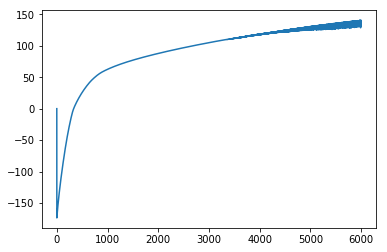

number inducing points:  3
alphas:  [ 7.0700531   7.49171066]
gamma:  0.0588653


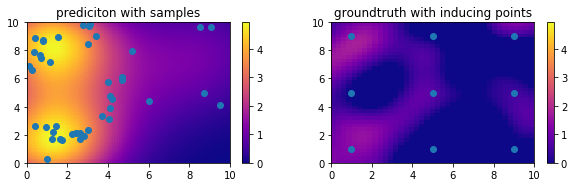

training and testbound:  [[ 210.60757446]] [[-9647.72460938]]


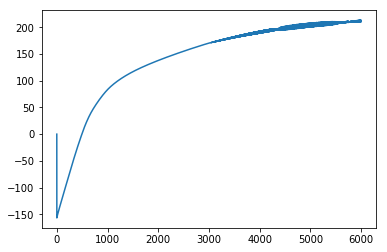

number inducing points:  4
alphas:  [ 7.6849432   8.38012409]
gamma:  0.053355


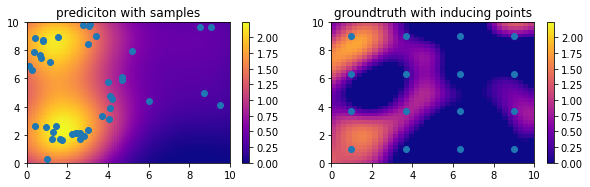

training and testbound:  [[ 227.04768372]] [[ 141.31173706]]


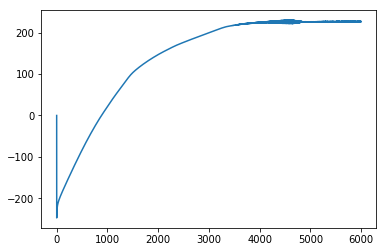

number inducing points:  5
alphas:  [ 6.70575953  6.87111187]
gamma:  0.182531


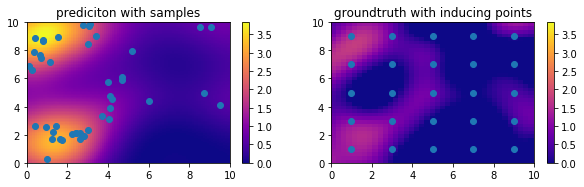

training and testbound:  [[ 102.8629303]] [[ 1865.82189941]]


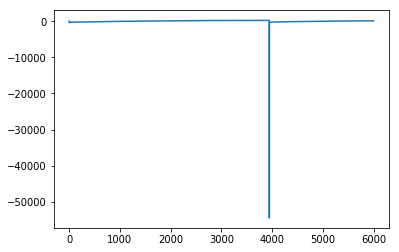

number inducing points:  6
alphas:  [ 4.38110304  4.39709854]
gamma:  -15.2058


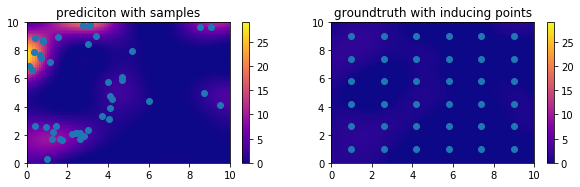

In [16]:
#groundtruth grid
xx, yy = np.meshgrid(np.linspace(Tmin, Tmax, res), np.linspace(Tmin, Tmax, res))

#evaluation grid
eval_res = 100
eval_x = np.linspace(Tmin, Tmax, eval_res)[:,na]
eval_y = np.linspace(Tmin, Tmax, eval_res)[:,na]
xx_eval, yy_eval = np.meshgrid(eval_x, eval_y)
eval_grid = np.array([xx_eval, yy_eval]).transpose(1,2,0).reshape(eval_res**2, 2)

num_iterations = 5
counter = 1


for i in np.arange(3,7): 
    
    m_opt, S_opt, Kzz_inv_opt, a_opt, Z_opt,g_opt,lower_bound_opt,bound_values = train_parameters(i,1, samples)
    
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,a_opt,g_opt,Z_opt,eval_grid)
    
    bound = get_lower_test_bound(test_samples,m_opt,S_opt,Kzz_inv_opt,a_opt,g_opt,Z_opt)
    print("training and testbound: ",lower_bound_opt, bound)
    
    #plots
    
    #print(bound_values.shape)
    #print(bound_values)
    plt.plot(bound_values)
   
    plt.show()
    
    cmap = plt.get_cmap('plasma')

    fig = plt.figure(figsize=(10,15)) 

    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)
  
    print("number inducing points: ",i)
    print("alphas: ",a_opt)
    print("gamma: ",g_opt)
    ax0 = ax0 = plt.subplot(num_iterations,2,counter)
    im = ax0.pcolormesh(xx_eval, yy_eval, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    #ax0.scatter(test_samples[:,0], test_samples[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)

    ax1 = ax0 = plt.subplot(num_iterations,2,counter+1)
    im1 = ax1.pcolormesh(xx,yy, plot_vals, cmap=cmap, norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tmin, Tmax)
    plt.ylim(Tmin, Tmax)
    counter += 2
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()
